In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append('..')

import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c
from py21cmfast import plotting, cache_tools

print(f'Using 21cmFAST version {p21c.__version__}')
if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    p21c.config['direc'] = '/scratch/submit/ctp/yitians/21cmFAST-cache'
p21c.global_params.ZPRIME_STEP_FACTOR= 1.05

Using 21cmFAST version 0.1.dev1578+g6f96f89.d20230216


/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## 0. Tmp

In [3]:
from dm21cm.common import get_circle_seq_at

In [29]:
cache_tools.clear_cache()

2023-02-20 21:00:58,932 | INFO | Removing PerturbedField_dd335247f9fd8328c14920834d2dd4f6_r54321.h5
2023-02-20 21:00:58,941 | INFO | Removing TsBox_a511f7e3a4129d80fe5611341e357a60_r54321.h5
2023-02-20 21:00:58,952 | INFO | Removing TsBox_f5f1575814f6de845f1495e10cf8d8ab_r54321.h5
2023-02-20 21:00:58,963 | INFO | Removing TsBox_f1abd1ad1a280c838af96b79cec890d6_r54321.h5
2023-02-20 21:00:58,968 | INFO | Removing PerturbedField_57d84f3f0bd0123e50daa01ff1896e85_r54321.h5
2023-02-20 21:00:58,972 | INFO | Removing PerturbedField_2ba81fff2d5f88ccd6d9872a401573fb_r54321.h5
2023-02-20 21:00:58,980 | INFO | Removing PerturbedField_12da56aac4851d785f548a72eb7c30bb_r54321.h5
2023-02-20 21:00:58,994 | INFO | Removing TsBox_471db891c37fd3287efa475c96407843_r54321.h5
2023-02-20 21:00:59,001 | INFO | Removing PerturbedField_a1dff3f86f079bf7f7fcbe890441de59_r54321.h5
2023-02-20 21:00:59,008 | INFO | Removing PerturbedField_442a73d9e3c00088472e8f15c4f7679d_r54321.h5
2023-02-20 21:00:59,015 | INFO | Rem

In [30]:
# initialize
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 50, "BOX_LEN": 50},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321, write=True
)

# redshift
# in DarkHistory: rs = 1 + z
end_z = 20 # set some low threshold
z_arr = [end_z]

while np.amax(z_arr) < p21c.global_params.Z_HEAT_MAX:
    prev_z = (1 + np.amax(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
    z_arr.append(prev_z)
    
z_arr = np.array(z_arr[::-1][1:])
z_arr = z_arr[:10] # only do ... steps
print(z_arr)

[34.91712652 33.20678716 31.57789254 30.02656432 28.54910888 27.14200845
 25.80191281 24.52563125 23.310125   22.1525    ]


In [31]:
for i_z, z in enumerate(z_arr):
    
    print(f'i_z={i_z} 1+z={1+z:.3f}')
    
    # input
    input_heating = p21c.input_heating(redshift=z, init_boxes=initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=z, init_boxes=initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=z, init_boxes=initial_conditions, write=False)

    input_heating.input_heating += get_circle_seq_at(50, 3, i_z)
    input_ionization.input_ionization += get_circle_seq_at(50, 5, 9-i_z) * 1e-3
    
    # perturbed_field to control redshift
    perturbed_field = p21c.perturb_field(redshift=z, init_boxes=initial_conditions)
    
    # calculate spin temperature
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=(None if i_z==0 else spin_temp),
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        write=True
    )

i_z=0 1+z=35.917


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=1 1+z=34.207


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=2 1+z=32.578


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=3 1+z=31.027


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=4 1+z=29.549


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=5 1+z=28.142


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=6 1+z=26.802


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=7 1+z=25.526


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=8 1+z=24.310


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=9 1+z=23.153


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation


## 1. Injection

In [38]:
import dm21cm.physics as phys

### 1.1 Evoli Messinger Ferrara

In [ ]:
def get_f_boxs(delta_B_box, x_e_box):
    
    return {
        'heat' : (1 + 2 * x_e_box) / 3,
        'ion'  : (1 - x_e_box) / 3,
        'exc'  : (1 - x_e_box) / 3,
    }

### 1.2 DarkHistory

In [46]:
# import darkhistory
if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    os.environ['DH_DIR'] = '/work/submit/yitians/darkhistory/DarkHistory'
    os.environ['DM21CM_DATA_DIR'] = '/data/submit/yitians/DM21cm'
sys.path.append(os.environ['DH_DIR'])
# import DM21cm
sys.path.append('..')

In [42]:
import jax.numpy as jnp

In [47]:
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools

from dm21cm.common import abscs_nBs_test
abscs = abscs_nBs_test

from dm21cm.interpolators import BatchInterpolator

In [48]:
DATA_DIR = os.environ['DM21CM_DATA_DIR'] + '/transferfunctions/nBs_test_2'
dep_interp = BatchInterpolator(DATA_DIR + '/phot_dep_dlnz4.879E-2_renxo_ad.p')

In [77]:
def get_f_boxs(delta_B_box, x_e_box, z=z, **process):
    
    # add check shape
    DIM = delta_B_box.shape[0]
    
    nBs_box = jnp.clip(jnp.array(1 + delta_B_box), 0, 15)
    nBs_in = nBs_box.flatten()
    x_box = jnp.array(x_e_box)
    x_in = x_box.flatten()
    
    spec = spectools.rebin_N_arr(np.array([1]), np.array([process['mDM']]), out_eng=abscs['photE'])
    spec_E = jnp.array(spec.N * spec.eng)
    spec_E /= jnp.sum(spec_E)
    f_boxs = dep_interp(1+z, spec.N, nBs_in, x_in).reshape(DIM, DIM, DIM, 5) / spec.toteng()
    
    out_absc = np.array(dep_interp.abscs['out'])
    
    return {
        'heat' : f_boxs[:,:,:, np.where(out_absc=='heat')[0][0]  ],
        'ion'  : f_boxs[:,:,:, np.where(out_absc=='H ion')[0][0] ] + f_boxs[:,:,:, np.where(out_absc=='He ion')[0][0] ],
        'exc'  : f_boxs[:,:,:, np.where(out_absc=='exc')[0][0]   ],
    }

## 2. test run

In [92]:
BOX_CF_LEN = 50 # [Mpc]
LOWRES_DIM = 50 # [1]
VOXEL_SIDE_CF_LENGTH = BOX_CF_LEN / LOWRES_DIM # [Mpc]

swave_process = dict(
    mode = 'swave',
    mDM = 1e10, # [eV]
    sigmav = 1e-26, # [cm^-3 s^-1]
)

decay_process = dict(
    mode = 'decay',
    mDM = 1e6, # [eV]
    lifetime = 3e25, # [s]
)

process = swave_process

In [93]:
z, z_next = z_arr[3], z_arr[4]

In [94]:
perturbed_field = p21c.perturb_field(redshift=z, init_boxes=initial_conditions) # [1] | delta_DM

In [95]:
ionized_box = p21c.ionize_box(spin_temp=spin_temp)

In [96]:
rho_DM_box = phys.rho_DM * (1+z)**3 * (1 + perturbed_field.density) # [eV cm^-3]
n_B_box = phys.n_B * (1+z)**3 * (1 + perturbed_field.density) # [cm^-3] | assuming delta_B = delta_DM
x_e_box = 1 - ionized_box.xH_box # [1]

dE_inj_dVdt_box = phys.inj_rate_box(rho_DM_box, **process) # [eV cm^-3 s^-1]
if process['mode'] == 'swave':
    dE_inj_dVdt_box *= phys.struct_boost_func(model='erfc')(1+z)

dE_inj_dV_box = dE_inj_dVdt_box * phys.dt_between_z(z, z_next) # [eV cm^-3]

In [97]:
f_boxs = get_f_boxs(perturbed_field.density, x_e_box, z=z, **process)

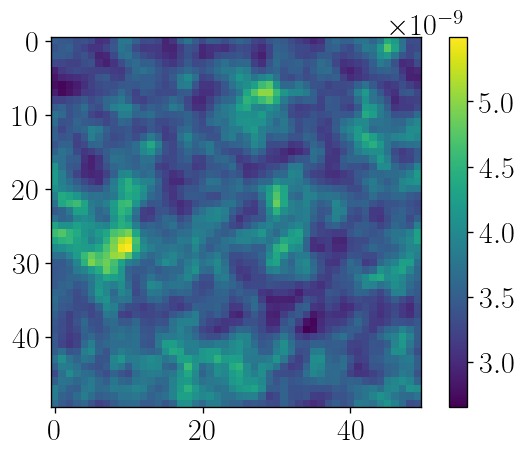

In [99]:
plt.imshow(f_boxs['heat'][25])
plt.colorbar()

In [100]:
input_heating_box = 2 / (3 * phys.kB * (1+x_e_box)) * dE_inj_dV_box * f_boxs['heat'] / n_B_box # [K] | [eV] per B / kb

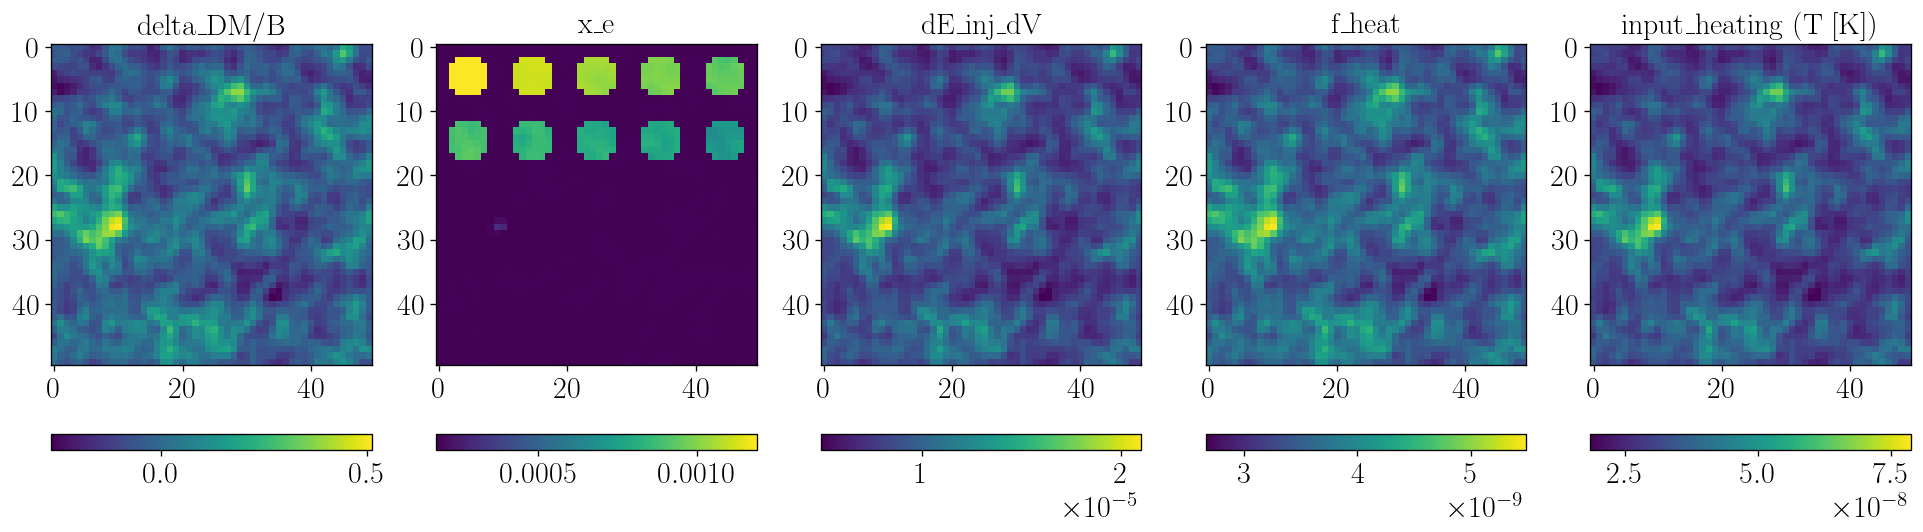

In [101]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

ims = []
ims.append(axs[0].imshow(perturbed_field.density[25]))
ims.append(axs[1].imshow(x_e_box[25]))
ims.append(axs[2].imshow(dE_inj_dV_box[25]))
ims.append(axs[3].imshow(f_boxs['heat'][25]))
ims.append(axs[4].imshow(input_heating_box[25]))

titles = ['delta_DM/B', 'x_e', 'dE_inj_dV', 'f_heat', 'input_heating (T [K])']

for i_im, im in enumerate(ims):
    axs[i_im].set(title=titles[i_im])
    fig.colorbar(im, ax=axs[i_im], orientation='horizontal')

## 2. run

In [4]:
cache_tools.clear_cache()

2023-02-20 12:31:06,463 | INFO | Removing InitialConditions_2eda6b944366038a89d6590f0449374d_r54321.h5
2023-02-20 12:31:06,500 | INFO | Removed 1 files from cache.


In [5]:
# initialize
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 50, "BOX_LEN": 50},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321, write=True
)

# redshift
# in DarkHistory: rs = 1 + z
end_z = 20 # set some low threshold
z_arr = [end_z]

while np.amax(z_arr) < p21c.global_params.Z_HEAT_MAX:
    prev_z = (1 + np.amax(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
    z_arr.append(prev_z)
    
z_arr = np.array(z_arr[::-1][1:][:10]) # only do 10 steps
print(z_arr)

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "


[34.91712652 33.20678716 31.57789254 30.02656432 28.54910888 27.14200845
 25.80191281 24.52563125 23.310125   22.1525    ]


In [6]:
Tk_box_arr = []

for i_z, z in enumerate(z_arr):
    
    print(f'i_z={i_z} 1+z={1+z:.3f}')
    
    # input
    input_heating = p21c.input_heating(redshift=z, init_boxes=initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=z, init_boxes=initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=z, init_boxes=initial_conditions, write=False)

    input_heating.input_heating += get_circle_seq_at(50, 3, i_z)
    input_ionization.input_ionization += get_circle_seq_at(50, 5, 9-i_z) * 1e-3
    
    # perturbed_field to control redshift
    perturbed_field = p21c.perturb_field(redshift=z, init_boxes=initial_conditions)
    
    # calculate spin temperature
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=(None if i_z==0 else spin_temp),
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        write=True
    )
    Tk_box_arr.append(spin_temp.Tk_box)

i_z=0 1+z=35.917


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=1 1+z=34.207


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=2 1+z=32.578


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=3 1+z=31.027


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=4 1+z=29.549


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=5 1+z=28.142


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=6 1+z=26.802


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=7 1+z=25.526


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=8 1+z=24.310


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=9 1+z=23.153


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation


### view result

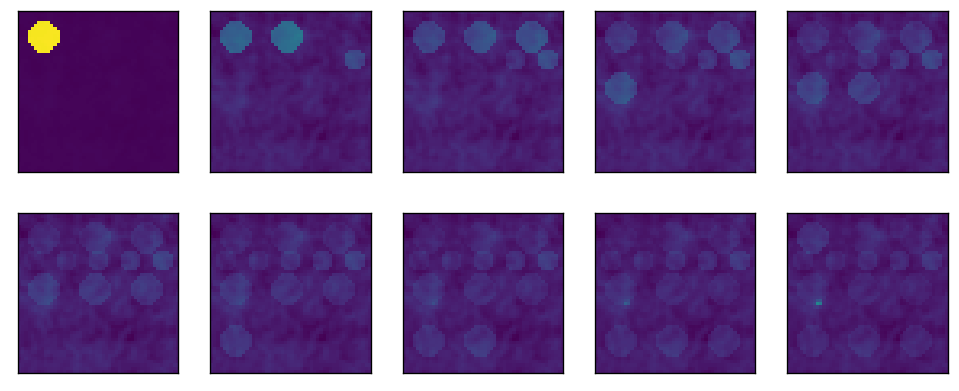

In [7]:
vmax = np.max(Tk_box_arr)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(Tk_box_arr[i*5+j][25], vmax=vmax)
        axs[i,j].set(xticks=[], yticks=[])

In [8]:
ionized_box = p21c.ionize_box(
    spin_temp = spin_temp,
)

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The followin

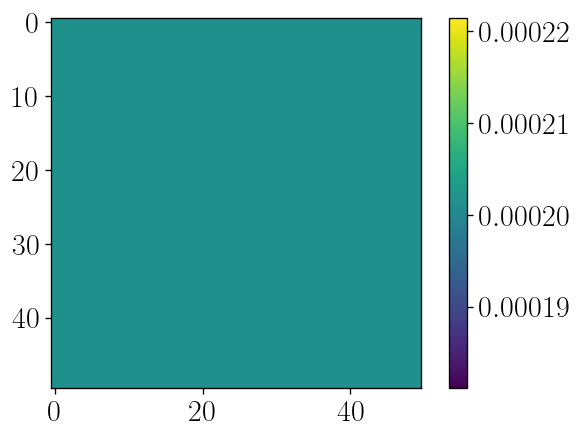

In [22]:
fig, ax = plt.subplots()
im = ax.imshow(1-ionized_box.xH_box[25])
fig.colorbar(im, ax=ax)

## Archive

[Text(0.5, 1.0, 'input ionization'), [], []]

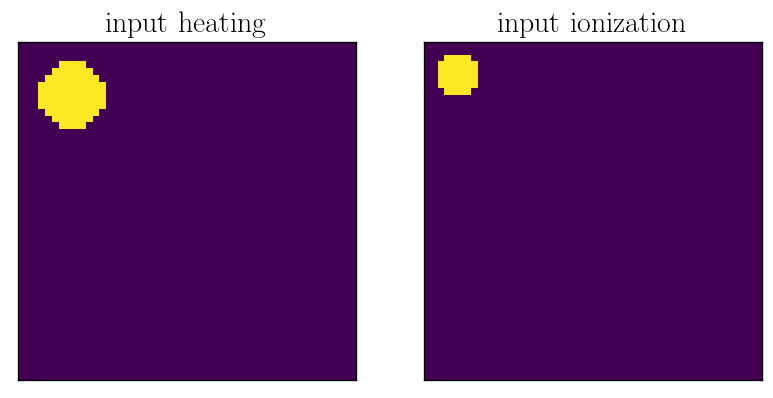

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
im0 = axs[0].imshow(input_heating.input_heating[25])
im1 = axs[1].imshow(input_ionization.input_ionization[25])

axs[0].set(title=r'input heating', xticks=[], yticks=[])
axs[1].set(title=r'input ionization', xticks=[], yticks=[])

#fig.colorbar(im0, ax=axs[0], orientation='horizontal')
#fig.colorbar(im1, ax=axs[1], orientation='horizontal')

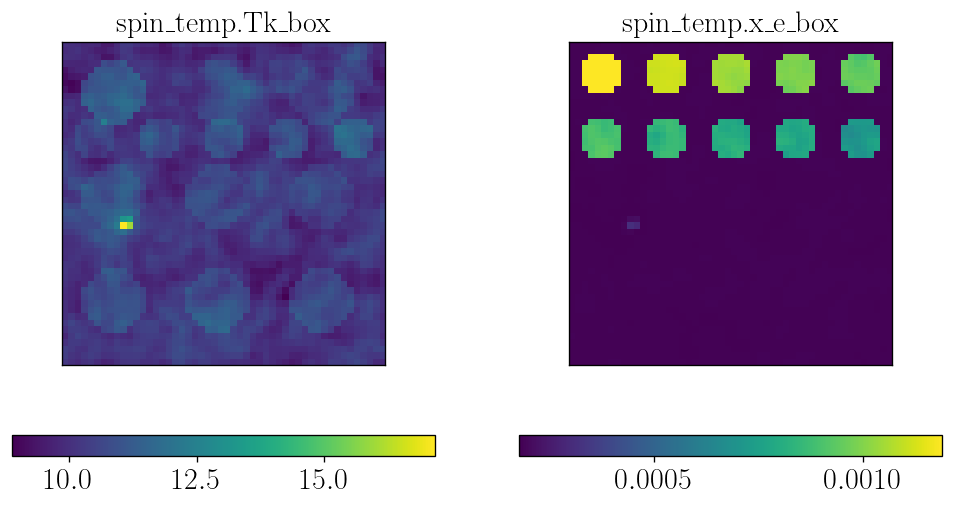

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im0 = axs[0].imshow(spin_temp.Tk_box[25])
im1 = axs[1].imshow(spin_temp.x_e_box[25])

axs[0].set(title='spin_temp.Tk_box', xticks=[], yticks=[])
axs[1].set(title='spin_temp.x_e_box', xticks=[], yticks=[])

fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')